In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
pip install audiomentations -q

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/genriflow')

from preprocessing import load_and_process_gtzan

X_train, X_test, X_val, y_train, y_test, y_val = load_and_process_gtzan(
    gtzan_path='/content/drive/MyDrive/gtzan_dataset/Data/genres_original',
    output_file = "/content/drive/MyDrive/Colab Notebooks/genriflow/processed_data.pkl",
    n_songs_per_genre=10,
    noise='weak',
    n_augmentations=0
)


Train MFCCs shape: (68, 8, 1292)
Train Mel Spectrogram shape: (68, 32, 1292)
Train Chroma shape: (68, 12, 1292)
Train Tonnetz shape: (68, 6, 1292)
Val MFCCs shape: (12, 8, 1292)
Val Mel Spectrogram shape: (12, 32, 1292)
Val Chroma shape: (12, 12, 1292)
Val Tonnetz shape: (12, 6, 1292)
Test MFCCs shape: (20, 8, 1292)
Test Mel Spectrogram shape: (20, 32, 1292)
Test Chroma shape: (20, 12, 1292)
Test Tonnetz shape: (20, 6, 1292)
X_train shape: (68, 58, 1292)
X_test shape: (20, 58, 1292)
X_val shape: (12, 58, 1292)


In [ ]:
import pickle
import numpy as np

with open("/content/drive/MyDrive/Colab Notebooks/genriflow/processed_data.pkl", "rb") as f:
    data_dict = pickle.load(f)

X = np.concatenate([data_dict['X_train'], data_dict['X_test'], data_dict['X_val']], axis=0)
y = np.concatenate([data_dict['y_train'], data_dict['y_test'], data_dict['y_val']], axis=0)

print("Data loaded successfully!")
print("X shape:", X.shape)
print("y shape:", y.shape)

Data loaded successfully!
X shape: (100, 58, 1292)
y shape: (100,)


In [ ]:
print(y)

['pop' 'jazz' 'classical' 'hiphop' 'reggae' 'reggae' 'rock' 'rock' 'jazz'
 'pop' 'blues' 'hiphop' 'pop' 'country' 'rock' 'metal' 'hiphop' 'reggae'
 'jazz' 'rock' 'metal' 'jazz' 'disco' 'blues' 'classical' 'blues' 'rock'
 'classical' 'jazz' 'disco' 'hiphop' 'country' 'pop' 'rock' 'disco' 'pop'
 'reggae' 'metal' 'disco' 'metal' 'pop' 'classical' 'metal' 'reggae'
 'hiphop' 'classical' 'disco' 'blues' 'country' 'disco' 'blues' 'hiphop'
 'rock' 'classical' 'reggae' 'hiphop' 'blues' 'reggae' 'rock' 'country'
 'classical' 'metal' 'classical' 'disco' 'hiphop' 'jazz' 'metal' 'disco'
 'reggae' 'rock' 'jazz' 'disco' 'disco' 'country' 'classical' 'reggae'
 'blues' 'pop' 'blues' 'country' 'jazz' 'country' 'metal' 'pop' 'jazz'
 'jazz' 'blues' 'country' 'classical' 'rock' 'pop' 'pop' 'country'
 'hiphop' 'blues' 'metal' 'hiphop' 'reggae' 'metal' 'country']


## PCA and GMMs for 10 clusters

In [ ]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

n_clusters = 10

X = np.array([element.flatten() for element in X])
pca = PCA(n_components=0.99)  # Preserve 90% of the variance
X_pca = pca.fit_transform(X)

print("Original shape:", X.shape)  # (50, 343863)
print("New shape after PCA:", X_pca.shape)  # (50, num_components)

gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm_labels = gmm.fit_predict(X_pca)

Original shape: (100, 74936)
New shape after PCA: (100, 97)


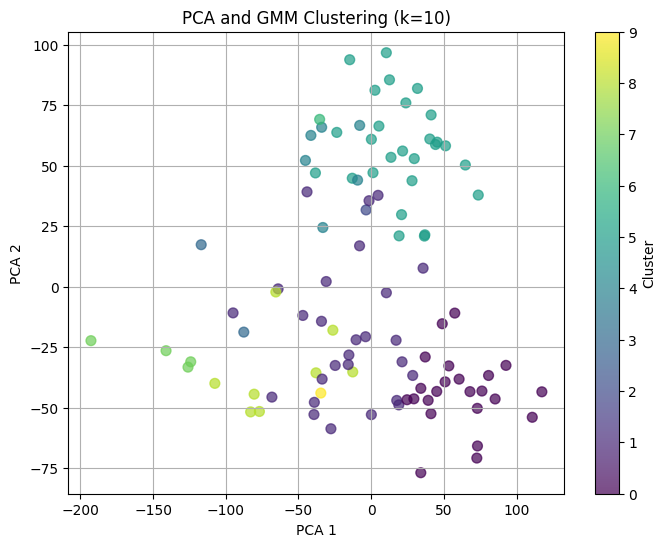

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='viridis', s=50, alpha=0.7)
plt.title("PCA and GMM Clustering (k=10)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label='Cluster')
plt.grid(True)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/genriflow/PCA_plot.pdf')
plt.show()


In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Your predicted_labels and true_labels (processed like before)

# First, we must encode true_labels to integers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
true_labels_encoded = le.fit_transform(y)

# Now calculate ARI and NMI
ari = adjusted_rand_score(true_labels_encoded, gmm_labels)
nmi = normalized_mutual_info_score(true_labels_encoded, gmm_labels)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")


Adjusted Rand Index (ARI): 0.1283
Normalized Mutual Information (NMI): 0.2958
